## Data Analysis using BulkLMM - BXD Longevity Study

In [1]:
using CSV, DelimitedFiles, DataFrames, Missings, XLSX
using LinearAlgebra, Statistics, Optim
using Random, Distributions, LoopVectorization
using GeneNetworkAPI, Downloads
using BenchmarkTools

In [2]:
using Plots

In [3]:
local_path = "../../BulkLMM.jl/src";

In [4]:
import LossFunctions: HuberLoss, value
import Distributions: Chisq,ccdf
import StatsBase: mad, sample

function huberize(y::Vector{Float64})
    m = median(y)
    s = mad(y,normalize=true)
    z = (y.-m)./s
    l = value.(HuberLoss(1),z)
    x = sign.(z).* sqrt.(2*l)
    return m .+ s.*x
end

huberize (generic function with 1 method)

## Load processed_data:

### By individuals:

In [5]:
BXD_pheno_ind_summary_df = CSV.read("data/GN886_pheno_summary.csv", DataFrame);

By individuals, there are 248 individual samples for 32445 livear proteome.

In [6]:
println(size(BXD_pheno_ind_summary_df)) 
BXD_pheno_ind_summary_df[1:10, 1:10]

(248, 32448)


Row,Sample,Strain,Strain_num,P42209_DESGLNRK_2,P42209_GLRPLDVAFLR_3,Q99M02_VGDPVYR_2,Q99M02_VWIYPIK_2,Q99M02_LCDPSVK_2,Q99M02_CVLTTVDPDTGIIDR_2,Q99M02_LVQFDTSMK_2
,String7,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,H1009,BXD9,9,11.349,11.534,17.587,17.517,17.309,16.574,16.323
2,H0370,BXD9,9,11.249,12.735,17.427,17.325,17.252,16.685,16.021
3,H2577,BXD9,9,12.415,10.487,17.89,17.488,17.594,16.731,16.208
4,H0365,BXD9,9,11.374,10.674,17.714,17.401,17.381,16.621,16.337
5,H1333,BXD13,13,11.687,11.524,17.362,17.367,17.071,16.465,15.97
6,H2259,BXD24,24,11.837,11.715,17.57,17.792,17.505,16.894,16.277
7,H1792,BXD24,24,11.563,11.434,17.789,17.847,17.416,17.042,16.292
8,H1791,BXD24,24,12.5,12.273,17.944,17.833,17.63,16.862,16.3
9,H1541,BXD24,24,11.815,11.564,17.794,17.759,17.456,16.878,16.377


In [7]:
BXD_geno_ind_summary_df = CSV.read("data/GN886_geno_summary.csv", DataFrame);

By individuals, there are 248 individual samples for 7321 markers.

In [8]:
println(size(BXD_geno_ind_summary_df)) 
BXD_geno_ind_summary_df[1:10, 1:10]

(248, 7324)


Row,Sample,Strain,Strain_num,rs31443144,rs6269442,rs32285189,rs258367496,rs32430919,rs36251697,rs30658298
,String7,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,H1009,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,H0370,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,H2577,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,H0365,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,H1333,BXD13,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,H2259,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,H1792,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,H1791,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,H1541,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### By strains:

In [9]:
BXD_pheno_strains_summary_df = CSV.read("data/GN886_pheno_strain_means_summary.csv", DataFrame);

By strains, there are 50 BXD strains for 32445 liver proteome.

In [10]:
println(size(BXD_pheno_strains_summary_df)) 
BXD_pheno_strains_summary_df[1:10, 1:10]

(50, 32447)


Row,Strain,Number of Samples,P42209_DESGLNRK_2,P42209_GLRPLDVAFLR_3,Q99M02_VGDPVYR_2,Q99M02_VWIYPIK_2,Q99M02_LCDPSVK_2,Q99M02_CVLTTVDPDTGIIDR_2,Q99M02_LVQFDTSMK_2,Q99M02_QLQQVGTVSK_2
,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,BXD9,4,11.5968,11.3575,17.6545,17.4327,17.384,16.6528,16.2222,16.3227
2,BXD13,1,11.687,11.524,17.362,17.367,17.071,16.465,15.97,15.98
3,BXD24,5,12.0778,11.7458,17.7926,17.8152,17.5168,16.9196,16.3012,16.4304
4,BXD27,3,11.717,11.149,17.336,17.3143,17.165,16.5283,15.9407,16.002
5,BXD29,11,11.735,11.3496,17.4583,17.3877,17.2431,16.4945,16.0869,16.1075
6,BXD32,8,11.6266,11.554,17.8254,17.7716,17.4639,16.9029,16.434,16.425
7,BXD34,13,11.7491,11.9135,17.6108,17.5974,17.2988,16.7761,16.3147,16.2926
8,BXD39,5,11.9158,11.719,17.395,17.385,17.157,16.5226,16.179,16.0594
9,BXD40,8,11.8651,11.6817,17.5986,17.6386,17.3861,16.6824,16.2855,16.2523


In [11]:
BXD_geno_strains_summary_df = CSV.read("data/GN886_geno_strains_summary.csv", DataFrame);

By strains, there are 50 BXD strains for 7321 markers.

In [12]:
println(size(BXD_geno_strains_summary_df)) 
BXD_geno_strains_summary_df[1:10, 1:10]

(50, 7322)


Row,Strain,rs31443144,rs6269442,rs32285189,rs258367496,rs32430919,rs36251697,rs30658298,rs51852623,rs31879829
,String7,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,BXD9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BXD13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BXD24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BXD27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,BXD29,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,BXD32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,BXD34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,BXD39,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,BXD40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Load functions:

In [103]:
include(joinpath(local_path, "kinship.jl"));
include(joinpath(local_path, "util.jl"));
include(joinpath(local_path, "wls.jl"));
include(joinpath(local_path, "lmm.jl"));
include(joinpath(local_path, "gridbrent.jl"));
include(joinpath(local_path, "transform_helpers.jl"));
include(joinpath(local_path, "scan.jl"));
include(joinpath(local_path, "bulkscan_helpers.jl"));
include(joinpath(local_path, "bulkscan.jl"));
include(joinpath(local_path, "readData.jl"));
include(joinpath(local_path, "../plot_utils/visuals_utils.jl"));
include(joinpath(local_path, "analysis_helpers/single_trait_analysis.jl"));

## Objectives

- gemma one trait, ind and strains

- scan_alt one trait, ind and strains

- scan_null one trait, ind and strains

- bulkscan_grid (null), all traits, ...

- data structure for all traits results...

- Heatmap grids_taken, compare on strain means and individuals

- Histogram of heritabilities (null) for all traits (both strain means and individual level data)

- Loglikelihood by h2_grid plot, strain means v.s. individuals

- Report fixed effects:

- Adjusting difference in the number of samples across strains

- Histogram of heritabilities (null) for all traits (both strain means and individual level data)

## Run BulkLMM.jl:

### Calculate kinship:

First, calculate the kinship matrix of relatedness among the strains (50-by-50):

In [14]:
geno_strains = Matrix{Float64}(BXD_geno_strains_summary_df[:, 2:end]);

In [15]:
kinship_strains = calcKinship(geno_strains);

Then, construct the kinship matrix of relatedness among the individuals based on which strain they are from:

In [16]:
function calcRepeats(x::Array{Int64, 1})
    
    counting_dict = Dict{Int64, Int64}();
    
    for i in 1:length(x)
        curr_key = x[i];
        if haskey(counting_dict, curr_key) # if current key already exists
            counting_dict[curr_key] += 1;
        else # if current key does not present, add it as a new key
            counting_dict[curr_key] = 1;
        end
    end
    
    return counting_dict
    
end

calcRepeats (generic function with 1 method)

In [17]:
function calcIndKinship_from_StrainKinship(kinship_strains::Array{Float64, 2}, 
                                           strain_info_about_samples::Array{Int64, 1})
    
    counting_dict = calcRepeats(strain_info_about_samples);
    reps_each_strain = map(x -> counting_dict[x], unique(strain_info_about_samples));
    
    # Initialize the placeholder:
    kinship_ind_from_strains = ones(sum(reps_each_strain), sum(reps_each_strain));

    # process the first BXD strain...
    reps_strain_1 = reps_each_strain[1];
    k_11 = kinship_strains[1, 1];
    # block_11 = ones(reps_strain_1, reps_strain_1);

    row_id = 0;
    col_id = 0;

    @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_1), 
                             (row_id+1):(row_id+reps_strain_1)] .*= k_11;

    for j in 2:length(reps_each_strain)
        reps_strain_j = reps_each_strain[j];
        k_1j = kinship_strains[1, j];
        # block_1j = ones(reps_strain_1, reps_strain_j);

        col_id += reps_each_strain[j-1];
        @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_1), 
                                 (col_id+1):(col_id+reps_strain_j)] .*= k_1j;

        # process the off-diagonal block conveniently...
        # block_j1 = ones(reps_strain_j, reps_strain_1);
        kinship_ind_from_strains[(col_id+1):(col_id+reps_strain_j),
                                 (row_id+1):(row_id+reps_strain_1)] .*= k_1j;

    end

    # process for the second BXD strain and all after...
    # for i in 2:length(reps_each_strain)
    for i in 2:length(reps_each_strain)

        reps_strain_i = reps_each_strain[i];
        k_ii = kinship_strains[i, i];
        # block_ii = ones(reps_strain_i, reps_strain_i);

        row_id += reps_each_strain[i-1];
        @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_i), 
                                 (row_id+1):(row_id+reps_strain_i)] .*= k_ii;

        col_id = row_id+reps_strain_i;

        for j in (i+1):length(reps_each_strain)

            reps_strain_j = reps_each_strain[j];
            k_ij = kinship_strains[i, j];
            # block_ij = ones(reps_strain_i, reps_strain_j);

            @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_i), 
                                     (col_id+1):(col_id+reps_strain_j)] .*= k_ij;

            # process the off-diagonal block conveniently...
            # block_ji = ones(reps_strain_j, reps_strain_i);
            @views kinship_ind_from_strains[(col_id+1):(col_id+reps_strain_j),
                                     (row_id+1):(row_id+reps_strain_i)] .*= k_ij;

            col_id += reps_each_strain[j];
        end
    
    end
    
    return kinship_ind_from_strains
end

calcIndKinship_from_StrainKinship (generic function with 1 method)

In [18]:
BXD_geno_ind_summary_df.Strain_num = Vector{Int64}(BXD_geno_ind_summary_df.Strain_num);

In [19]:
@time kinship_ind_from_strains = calcIndKinship_from_StrainKinship(kinship_strains, BXD_geno_ind_summary_df.Strain_num);

  0.000330 seconds (76 allocations: 503.766 KiB)


Compare the runtime with directly calculating the kinship matrix from individual genotype data:

In [20]:
round.(kinship_ind_from_strains[1:10, 1:10], digits = 2)

10×10 Matrix{Float64}:
 1.0   1.0   1.0   1.0   0.55  0.58  0.58  0.58  0.58  0.58
 1.0   1.0   1.0   1.0   0.55  0.58  0.58  0.58  0.58  0.58
 1.0   1.0   1.0   1.0   0.55  0.58  0.58  0.58  0.58  0.58
 1.0   1.0   1.0   1.0   0.55  0.58  0.58  0.58  0.58  0.58
 0.55  0.55  0.55  0.55  1.0   0.56  0.56  0.56  0.56  0.56
 0.58  0.58  0.58  0.58  0.56  1.0   1.0   1.0   1.0   1.0
 0.58  0.58  0.58  0.58  0.56  1.0   1.0   1.0   1.0   1.0
 0.58  0.58  0.58  0.58  0.56  1.0   1.0   1.0   1.0   1.0
 0.58  0.58  0.58  0.58  0.56  1.0   1.0   1.0   1.0   1.0
 0.58  0.58  0.58  0.58  0.56  1.0   1.0   1.0   1.0   1.0

In [21]:
geno_ind = Matrix{Float64}(BXD_geno_ind_summary_df[:, 4:end]);

In [22]:
@time kinship_ind_from_ind = calcKinship(geno_ind);

  5.442911 seconds (306.28 k allocations: 8.368 GiB, 14.57% gc time)


In [23]:
maximum(abs.(kinship_ind_from_ind .- kinship_ind_from_strains))

0.04186586531894554

### Single-trait genome scans:

To see single trait genome scan results, we take the 29437-th livear proteomic as the single trait to run analysis:  

In [24]:
lp_names = names(BXD_pheno_ind_summary_df)[4:end];

In [25]:
lp_id = 29437;
lp_names[lp_id]

"Q9Z2I8_SSGLPITSAVDLEDAAK_3"

In [26]:
prior = [1.0, 0.1];

#### For individual liver proteome

In [27]:
lp_ind_Y = Matrix{Float64}(BXD_pheno_ind_summary_df[:, 4:end]);
lp_ind_y = reshape(lp_ind_Y[:, lp_id], :, 1);

In [28]:
lpst_ind_Y = colStandardize(lp_ind_Y);
lpst_ind_y = reshape(lpst_ind_Y[:, lp_id], :, 1);

Loglik plot: 


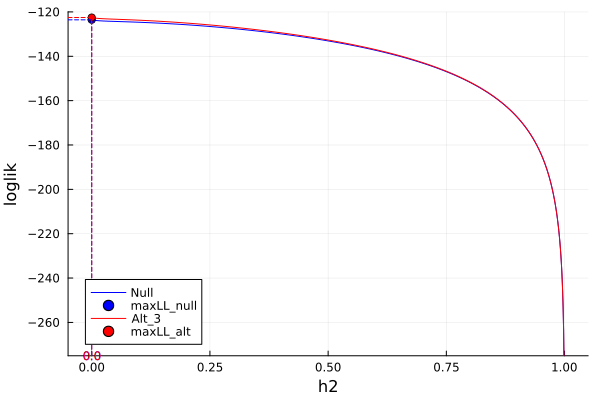

 11.792717 seconds (21.90 M allocations: 1.302 GiB, 5.00% gc time, 95.89% compilation time: 13% of which was recompilation)


GKS: could not find font below.ttf


In [29]:
@time scan_results_ind = scan(lpst_ind_y, geno_ind, kinship_ind_from_strains;
                              prior_variance = prior[1], prior_sample_size = prior[2],
                              plot_loglik = true, markerID = 3, h2_grid = collect(0.0:999).*0.001,
                              x_lims = [0.0, 1.0], y_lims = [-275, -120.0]);

In [30]:
BLAS.set_num_threads(Threads.nthreads())

In [31]:
BLAS.get_num_threads()

1

In [32]:
@time scan_results_ind_alt = scan(lpst_ind_y, geno_ind, kinship_ind_from_strains;
                                  assumption = "alt", 
                                  prior_variance = prior[1], prior_sample_size = prior[2]);

 11.365944 seconds (11.79 M allocations: 14.369 GiB, 28.82% gc time, 0.32% compilation time)


In [33]:
@time scan_perms_results_ind = scan(lpst_ind_y, geno_ind, kinship_ind_from_strains;
                                    prior_variance = prior[1], prior_sample_size = prior[2],
                                    permutation_test = true, nperms = 1000, original = true);

  0.817561 seconds (1.53 M allocations: 237.183 MiB, 3.24% gc time, 69.50% compilation time)


In [34]:
max_lods = vec(mapslices(x -> maximum(x), scan_perms_results_ind; dims = 1));

In [35]:
thrs = map(x -> quantile(max_lods, x), [0.85, 0.95]);

In [36]:
lp_id

29437

In [37]:
mean(scan_perms_results_ind[:, 1] .> 2.94)

0.0

In [38]:
thrs

2-element Vector{Float64}:
 2.9331062815664715
 3.4166702474006114

In [39]:
single_results_ind = DataFrame(hcat(scan_results_ind.lod, scan_results_ind_alt.lod, scan_perms_results_ind[:, 1]), ["scan_null", "scan_alt", "scan_perms.original"]);

In [40]:
single_results_ind[1:6, :]

Row,scan_null,scan_alt,scan_perms.original
,Float64,Float64,Float64
1,0.44861,0.448609,0.44861
2,0.44861,0.448609,0.44861
3,0.44861,0.448609,0.44861
4,0.44861,0.448609,0.44861
5,0.44861,0.448609,0.44861
6,0.44861,0.448609,0.44861


#### For liver proteome means by strains

In [41]:
lp_strains_Y = Matrix{Float64}(BXD_pheno_strains_summary_df[:, 3:end]);
lp_strains_y = reshape(lp_strains_Y[:, lp_id], :, 1);

In [42]:
lpst_strains_Y = colStandardize(lp_strains_Y);
lpst_strains_y = reshape(lpst_strains_Y[:, lp_id], :, 1);

In [87]:
@time scan_results_strains = scan(lpst_strains_y, geno_strains, kinship_strains; 
                                  prior_variance = prior[1], prior_sample_size = prior[2],
                                  optim_interval = 4);

  0.032653 seconds (83.86 k allocations: 33.094 MiB)


In [44]:
@time scan_results_strains_alt = scan(lpst_strains_y, geno_strains, kinship_strains;
                                      assumption = "alt",
                                      prior_variance = prior[1], prior_sample_size = prior[2]);

  1.079429 seconds (4.08 M allocations: 1.234 GiB, 19.42% gc time)


In [45]:
@time scan_perms_results_strains = scan(lpst_strains_y, geno_strains, kinship_strains;
                                        permutation_test = true, nperms = 1000, original = true, 
                                        prior_variance = prior[1], prior_sample_size = prior[2]);

  0.130010 seconds (183.05 k allocations: 83.958 MiB, 24.71% compilation time)


In [46]:
single_results_strains = DataFrame(hcat(scan_results_strains.lod, scan_results_strains_alt.lod, scan_perms_results_strains[:, 1]), ["scan_null", "scan_alt", "scan_perms.original"]);

In [47]:
single_results_strains[1:6, :]

Row,scan_null,scan_alt,scan_perms.original
,Float64,Float64,Float64
1,0.363103,0.359619,0.363103
2,0.363103,0.359619,0.363103
3,0.363103,0.359619,0.363103
4,0.363103,0.359619,0.363103
5,0.363103,0.359619,0.363103
6,0.363103,0.359619,0.363103


In [48]:
size(lp_strains_y)

(50, 1)

In [49]:
lpst_strains_y[1:5]./sqrt(0.5)

5-element Vector{Float64}:
  1.0226201850024244
 -0.007395742683977131
  0.8020068444624721
  1.234467432540759
 -0.5639098286938068

### Weighted Error Variances:

Assuming that

$$y = X_0 B_0+g\beta+\epsilon$$

where 

$$\epsilon \sim N(0,  \sigma^2_g K + \sigma^2_e V) $$ and 

the matrix $V$ is a diagonal but not necessarily an identity matrix.

Notice that since $V^{-1} = V^{-1/2}V^{-1/2}$, then the strategy is as such:

Let $$y^* = V^{-1/2}y = V^{-1/2}X0+V^{-1/2}g\beta+V^{-1/2}\epsilon$$

then 
$$V^{-1/2}\epsilon \sim N(0, \sigma^2_g V^{-1/2}KV^{-1/2}+\sigma^2_e V^{-1/2}VV^{-1/2} = \sigma^2_g K^*+\sigma^2_e I)$$

In [52]:
BXD_pheno_ind_summary_df[1:6, :]

Row,Sample,Strain,Strain_num,P42209_DESGLNRK_2,P42209_GLRPLDVAFLR_3,Q99M02_VGDPVYR_2,Q99M02_VWIYPIK_2,Q99M02_LCDPSVK_2,Q99M02_CVLTTVDPDTGIIDR_2,Q99M02_LVQFDTSMK_2,Q99M02_QLQQVGTVSK_2,Q99M02_KLYPSESYLQNYEVAYPDCSPVHLISEASLVDLNTR_4,Q99M02_GRDCGDEVAQWFTNYLK_3,Q99M02_SIYQSSPLFGMYFSVEK_2,Q99M02_RQLQQVGTVSK_3,Q99M02_LYPSESYLQNYEVAYPDCSPVHLISEASLVDLNTR_4,Q99M02_KLYPSESYLQNYEVAYPDCSPVHLISEASLVDLNTR_5,Q99M02_SIYQSSPLFGMYFSVEK_3,Q99M02_CVLTTVDPDTGIIDRK_3,Q99M02_CVLTTVDPDTGIIDR_3,Q99M02_TQAYRLVQFDTSMK_3,Q99M02_GVSVCETECTDMGLR_2,Q99M02_DCGDEVAQWFTNYLK_2,Q99M02_DRFWMVVK_2,Q99M02_GRDCGDEVAQWFTNYLK_2,Q99M02_DCGDEVAQWFTNYLK_3,Q99M02_EDGHMVTAR_2,Q99M02_RQLQQVGTVSK_2,P42208_TIISYIDEQFER_2,P42208_ILDEIEEHSIK_3,P42208_VNIVPVIAK_2,P42208_ASIPFSVVGSNQLIEAK_2,P42208_TVQIEASTVEIEER_2,P42208_LTVVDTPGYGDAINCR_2,P42208_ASIPFSVVGSNQLIEAK_3,P42208_STLINSLFLTDLYPER_3,Q9Z1S5_VNIIPVIAK_2,Q3KNM2_LGPVVYVLDLADR_2,Q9Z2Q6_LATPEDKQDIDKQYVGFATLPNQVHR_4,Q9Z2Q6_VNIVPILAK_2,Q9R1T4_RNEFLGELQK_3,Q9R1T4_STLMDTLFNTK_2,O55131_STLINSLFLTDLYSPEYPGPSHR_3,O55131_FEDYLNAESR_2,O55131_IYEFPETDDEEENKLVK_3,O55131_NLEGYVGFANLPNQVYR_2,O55131_DVTNNVHYENYR_3,O55131_ANWEAQQR_2,O55131_NLEGYVGFANLPNQVYR_3,O55131_ADTLTPEECQQFK_2,O55131_ILEQQNSSR_2,O55131_VQCCLYFIAPSGHGLKPLDIEFMK_4,O55131_TVQVEQSK_2,O55131_LKDSEAELQR_2,Q8CHH9_VNIIPLIAK_2,Q8CHH9_VNIIPIIAK_2,Q80UG5_ADTLTLEER_2,Q80UG5_STLINTLFK_2,Q80UG5_RTEITIVKPQESVLR_4,Q80UG5_DITSNIHFEAYR_3,Q80UG5_LEPRPSVAEVPYR_3,Q80UG5_FINDQYEK_2,Q80UG5_YLQEEVNINR_2,Q80UG5_VVNIVPVIAK_2,Q80UG5_SITHDIEEK_2,Q80UG5_IPEGSAVPATDAAPK_2,Q80UG5_SVQPTSEER_2,Q80UG5_QVESTASAAGPSR_2,Q8C1B7_FESDPATHNEPGVR_3,Q8C1B7_SYELQESNVR_2,Q8C1B7_NLSLSGHVGFDSLPDQLVNK_3,Q8C1B7_AAAQLLQSQAQQSGAQQTK_3,Q8C1B7_ELEEEVSNFQK_2,Q9ERR7_WNTDSVEEFLSEK_2,Q9ERR7_LLDDNGNIAEELSILK_2,Q9ERY9_YLEAEPVSR_2,P59708_ITAEEMYDIFGK_2,Q9DCS2_CLDSIAATTR_2,Q9DCS2_ISPQSNVDFDLTLR_2,Q9DCS2_VLEVASGSGQHAAHFAQAFPNAEWQPSDVDQR_4,Q9DCS2_QYVDPAQR_2,Q9DCS2_NKEPILSVLR_2,Q9DCS2_AQGLSNVK_2,Q9DCS2_VLEVASGSGQHAAHFAQAFPNAEWQPSDVDQR_5,Q9DCS2_MVDMPANNK_2,Q9DCS2_DTVLLEELGQASGLVLER_3,Q9DCS2_DTVLLEELGQASGLVLER_2,Q9JHJ3_LLHTADVCQLEVALVGASPR_3,A2A8E1_TIVEFECR_2,A2A8E1_ATLENVTNLRPVGEDFR_3,A2A8E1_ENSIDILSSTIK_2,A2A8E1_AQESVGIFEVTHQFVK_3,Q8BWR2_GLAYGLYLR_2,Q8VED9_IQTLSAIDTIK_2,Q9CRB3_LFFDTER_2,Q9CRB3_FHVPLLLSPWSYTTYR_3,Q9CRB3_TSYTNLDGR_2,Q9CRB3_LEAPCQQWMELR_2,Q9CRB3_CPGLLTPSQIKPGTYK_3,Q9CRB3_LEAPCQQWMELR_3,⋯
,String7,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,H1009,BXD9,9,11.349,11.534,17.587,17.517,17.309,16.574,16.323,16.263,16.24,16.052,15.355,15.795,15.4,15.03,14.831,14.914,14.755,14.389,14.272,13.992,14.291,13.762,13.167,12.662,10.913,14.723,14.348,13.345,14.228,13.862,13.902,13.687,11.613,10.245,14.409,15.147,12.34,14.404,13.775,14.293,14.461,14.23,14.065,14.258,14.31,13.616,13.541,13.46,13.293,12.937,12.717,15.149,14.36,14.833,14.341,14.579,14.316,14.049,13.817,13.656,13.297,13.78,12.843,12.439,11.074,14.065,13.915,13.994,13.907,13.247,13.356,12.815,14.702,13.637,16.398,16.402,16.271,16.0,15.909,15.647,15.021,13.726,7.236,3.295,13.794,14.838,14.908,14.664,13.055,12.612,13.323,18.252,16.889,17.118,16.443,15.683,14.183,⋯
2,H0370,BXD9,9,11.249,12.735,17.427,17.325,17.252,16.685,16.021,16.332,15.965,15.624,15.336,14.811,14.979,14.957,14.474,14.815,14.912,14.77,14.244,14.151,13.87,13.696,11.285,13.094,1

In [53]:
BXD_pheno_strains_summary_df[1:6, :]

Row,Strain,Number of Samples,P42209_DESGLNRK_2,P42209_GLRPLDVAFLR_3,Q99M02_VGDPVYR_2,Q99M02_VWIYPIK_2,Q99M02_LCDPSVK_2,Q99M02_CVLTTVDPDTGIIDR_2,Q99M02_LVQFDTSMK_2,Q99M02_QLQQVGTVSK_2,Q99M02_KLYPSESYLQNYEVAYPDCSPVHLISEASLVDLNTR_4,Q99M02_GRDCGDEVAQWFTNYLK_3,Q99M02_SIYQSSPLFGMYFSVEK_2,Q99M02_RQLQQVGTVSK_3,Q99M02_LYPSESYLQNYEVAYPDCSPVHLISEASLVDLNTR_4,Q99M02_KLYPSESYLQNYEVAYPDCSPVHLISEASLVDLNTR_5,Q99M02_SIYQSSPLFGMYFSVEK_3,Q99M02_CVLTTVDPDTGIIDRK_3,Q99M02_CVLTTVDPDTGIIDR_3,Q99M02_TQAYRLVQFDTSMK_3,Q99M02_GVSVCETECTDMGLR_2,Q99M02_DCGDEVAQWFTNYLK_2,Q99M02_DRFWMVVK_2,Q99M02_GRDCGDEVAQWFTNYLK_2,Q99M02_DCGDEVAQWFTNYLK_3,Q99M02_EDGHMVTAR_2,Q99M02_RQLQQVGTVSK_2,P42208_TIISYIDEQFER_2,P42208_ILDEIEEHSIK_3,P42208_VNIVPVIAK_2,P42208_ASIPFSVVGSNQLIEAK_2,P42208_TVQIEASTVEIEER_2,P42208_LTVVDTPGYGDAINCR_2,P42208_ASIPFSVVGSNQLIEAK_3,P42208_STLINSLFLTDLYPER_3,Q9Z1S5_VNIIPVIAK_2,Q3KNM2_LGPVVYVLDLADR_2,Q9Z2Q6_LATPEDKQDIDKQYVGFATLPNQVHR_4,Q9Z2Q6_VNIVPILAK_2,Q9R1T4_RNEFLGELQK_3,Q9R1T4_STLMDTLFNTK_2,O55131_STLINSLFLTDLYSPEYPGPSHR_3,O55131_FEDYLNAESR_2,O55131_IYEFPETDDEEENKLVK_3,O55131_NLEGYVGFANLPNQVYR_2,O55131_DVTNNVHYENYR_3,O55131_ANWEAQQR_2,O55131_NLEGYVGFANLPNQVYR_3,O55131_ADTLTPEECQQFK_2,O55131_ILEQQNSSR_2,O55131_VQCCLYFIAPSGHGLKPLDIEFMK_4,O55131_TVQVEQSK_2,O55131_LKDSEAELQR_2,Q8CHH9_VNIIPLIAK_2,Q8CHH9_VNIIPIIAK_2,Q80UG5_ADTLTLEER_2,Q80UG5_STLINTLFK_2,Q80UG5_RTEITIVKPQESVLR_4,Q80UG5_DITSNIHFEAYR_3,Q80UG5_LEPRPSVAEVPYR_3,Q80UG5_FINDQYEK_2,Q80UG5_YLQEEVNINR_2,Q80UG5_VVNIVPVIAK_2,Q80UG5_SITHDIEEK_2,Q80UG5_IPEGSAVPATDAAPK_2,Q80UG5_SVQPTSEER_2,Q80UG5_QVESTASAAGPSR_2,Q8C1B7_FESDPATHNEPGVR_3,Q8C1B7_SYELQESNVR_2,Q8C1B7_NLSLSGHVGFDSLPDQLVNK_3,Q8C1B7_AAAQLLQSQAQQSGAQQTK_3,Q8C1B7_ELEEEVSNFQK_2,Q9ERR7_WNTDSVEEFLSEK_2,Q9ERR7_LLDDNGNIAEELSILK_2,Q9ERY9_YLEAEPVSR_2,P59708_ITAEEMYDIFGK_2,Q9DCS2_CLDSIAATTR_2,Q9DCS2_ISPQSNVDFDLTLR_2,Q9DCS2_VLEVASGSGQHAAHFAQAFPNAEWQPSDVDQR_4,Q9DCS2_QYVDPAQR_2,Q9DCS2_NKEPILSVLR_2,Q9DCS2_AQGLSNVK_2,Q9DCS2_VLEVASGSGQHAAHFAQAFPNAEWQPSDVDQR_5,Q9DCS2_MVDMPANNK_2,Q9DCS2_DTVLLEELGQASGLVLER_3,Q9DCS2_DTVLLEELGQASGLVLER_2,Q9JHJ3_LLHTADVCQLEVALVGASPR_3,A2A8E1_TIVEFECR_2,A2A8E1_ATLENVTNLRPVGEDFR_3,A2A8E1_ENSIDILSSTIK_2,A2A8E1_AQESVGIFEVTHQFVK_3,Q8BWR2_GLAYGLYLR_2,Q8VED9_IQTLSAIDTIK_2,Q9CRB3_LFFDTER_2,Q9CRB3_FHVPLLLSPWSYTTYR_3,Q9CRB3_TSYTNLDGR_2,Q9CRB3_LEAPCQQWMELR_2,Q9CRB3_CPGLLTPSQIKPGTYK_3,Q9CRB3_LEAPCQQWMELR_3,Q9CRB3_CPGLLTPSQIKPGTYK_2,⋯
,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,BXD9,4,11.5968,11.3575,17.6545,17.4327,17.384,16.6528,16.2222,16.3227,16.1728,15.9748,15.389,15.5355,15.2248,15.0568,14.8253,14.9138,14.701,14.4827,14.435,14.1852,14.181,13.767,12.6575,13.0293,12.1615,14.4335,14.329,13.121,13.7155,13.792,13.6792,13.588,10.4722,10.8012,14.4032,15.1105,12.296,13.9857,13.5813,14.4152,14.314,14.0682,14.0802,14.0095,14.2483,13.491,13.2422,13.0218,13.1207,12.596,12.545,15.0785,14.098,14.998,14.2985,14.5045,14.4415,14.059,13.7245,13.7157,13.0465,13.9132,12.589,12.211,11.2688,13.8725,13.8287,13.6202,13.7073,13.2155,13.211,12.4328,14.7125,13.2955,16.292,16.3242,16.059,15.9615,15.9207,15.8298,14.756,13.4055,10.155,10.0538,13.8277,15.0023,14.9838,14.7153,13.053,13.0248,13.3317,18.24,17.0547,17.0873,16.1775,15.6133,14.0457,13.528,⋯
2,BXD13,1,11.687,11.524,17.362,17.367,17.071,16.465,15.97,15.98,16.108,1

In [54]:
# weights_true = float.(1.0 ./BXD_pheno_strains_summary_df[:, 2]);
weights_true = sqrt.(BXD_pheno_strains_summary_df[:, 2]);

In [55]:
@time lod_from_pkg = scan(lpst_strains_y, geno_strains, kinship_strains;
                          weights = weights_true,
                          prior_variance = prior[1], prior_sample_size = prior[2]);

  0.204839 seconds (579.14 k allocations: 63.000 MiB, 83.67% compilation time)


In [56]:
lod_from_pkg.lod[1:10]

10-element Vector{Float64}:
 0.4454216995526783
 0.4454216995526783
 0.4454216995526783
 0.4454216995526783
 0.4454216995526783
 0.4454216995526783
 0.4454216995526783
 0.4454216995526783
 0.4454216995526783
 0.4454216995526783

In [57]:
lod_from_pkg.lod[1:10]

10-element Vector{Float64}:
 0.4454216995526783
 0.4454216995526783
 0.4454216995526783
 0.4454216995526783
 0.4454216995526783
 0.4454216995526783
 0.4454216995526783
 0.4454216995526783
 0.4454216995526783
 0.4454216995526783

In [58]:
lpst_strains_y_test = rowMultiply(lpst_strains_y, weights_true);
geno_strains_test = rowMultiply(geno_strains, weights_true);
covar_strains_test = rowMultiply(ones(50, 1), weights_true);
# kinship_strains_test = rowMultiply(kinship_strains, weights_true);

In [59]:
test_W = rowMultiply(kinship_strains, weights_true);

In [60]:
test_K = rowMultiply(permutedims(test_W), weights_true);

In [61]:
lod_by_hand = scan(lpst_strains_y_test, geno_strains_test, covar_strains_test, test_K;
                   addIntercept = false, 
                   prior_variance = prior[1], prior_sample_size = prior[2]);

In [62]:
sum(abs.(lod_by_hand.lod .- lod_from_pkg.lod))

9.634922359946785e-6

In [63]:
lp_id

29437

In [132]:
lp_names[lp_id]

"Q9Z2I8_SSGLPITSAVDLEDAAK_3"

### Test:

In [65]:
typeof(missing)

Missing

In [66]:
a = missing

missing

In [67]:
@time ismissing(a)

  0.000001 seconds


true

In [126]:
test_a = scan_null(lpst_strains_y_test, geno_strains_test, 
                   covar_strains_test, test_K,
                   prior, false; optim_interval = 10);

In [100]:
@time test_A = bulkscan_null_grid(lpst_strains_Y, geno_strains, kinship_strains, grid_list;
                                  weights = weights_true, 
                                  prior_variance = 1.0, prior_sample_size = 0.1);

 13.778711 seconds (45.94 M allocations: 12.248 GiB, 9.73% gc time)


In [101]:
test_A.h2_null_list[lp_id]

0.0

In [112]:
lod_from_pkg.h2_null

0.474419778638072

In [127]:
maximum(abs.(test_a.lod .- lod_by_hand.lod))

0.8925840081786263

In [129]:
test_a.h2_null

3.8006057647275933e-16

In [89]:
scan_results_strains.h2_null

3.6023885132639637e-16

In [90]:
bulkscan_results_strains = bulkscan_null_grid(lpst_strains_Y, geno_strains, kinship_strains, grid_list;
                                              prior_variance = 1.0, prior_sample_size = 0.1);

In [131]:
bulkscan_results_strains.h2_null_list[lp_id]

0.0

In [98]:
maximum(abs.(bulkscan_results_strains.L[:, lp_id] .- scan_results_strains.lod))

5.773159728050814e-15

In [105]:
@time test_A_exact = bulkscan_null(lpst_strains_Y, geno_strains, kinship_strains; nb = Threads.nthreads(),
                                   weights = weights_true, 
                                   prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 4);

416.451647 seconds (2.67 G allocations: 449.095 GiB, 10.78% gc time, 0.05% compilation time)


In [107]:
test_A_exact.h2_null_list[lp_id]

0.4744197815158777

In [130]:
test_A.h2_null_list[lp_id]

0.0

In [119]:
hcat(test_A_exact.L[:, lp_id], test_a, test_A.L[:, lp_id])

7321×3 Matrix{Float64}:
 0.445422   0.444145   0.445899
 0.445422   0.444145   0.445899
 0.445422   0.444145   0.445899
 0.445422   0.444145   0.445899
 0.445422   0.444145   0.445899
 0.445422   0.444145   0.445899
 0.445422   0.444145   0.445899
 0.445422   0.444145   0.445899
 0.445422   0.444145   0.445899
 0.445422   0.444145   0.445899
 0.445422   0.444145   0.445899
 0.445422   0.444145   0.445899
 0.140874   0.026578   0.025037
 ⋮                     
 0.242951   0.321163   0.343775
 0.242951   0.321163   0.343775
 0.242951   0.321163   0.343775
 0.0170998  0.0483146  0.0572317
 0.241847   0.334049   0.357469
 0.241847   0.334049   0.357469
 0.11357    0.160293   0.176429
 0.0244759  0.0934784  0.10757
 0.11357    0.160293   0.176429
 0.0244759  0.0934784  0.10757
 0.104616   0.158307   0.178015
 0.104616   0.158307   0.178015

### Multiple-trait genome scans:

In [78]:
BLAS.set_num_threads(Threads.nthreads())

In [79]:
BLAS.get_num_threads()

1

In [80]:
grid_list = collect(0.0:0.01:0.99);

#### For individual liver proteome

In [81]:
size(lpst_ind_Y)

(248, 32445)

In [82]:
size(lpst_strains_Y)

(50, 32445)

In [ ]:
@time bulkscan_results_ind_null = bulkscan_null(lpst_ind_Y, geno_ind, kinship_ind_from_strains; nb = Threads.nthreads(),
                                                prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 4);

In [ ]:
BLAS.set_num_threads(Threads.nthreads())

In [ ]:
@time bulkscan_results_ind_alt_grid = bulkscan_alt_grid(lpst_ind_Y, geno_ind, kinship_ind_from_strains, grid_list);

In [ ]:
@time bulkscan_results_ind_null_grid = bulkscan_null_grid(lpst_ind_Y, geno_ind, kinship_ind_from_strains, grid_list);

#### For liver proteome means by strains

In [104]:
@time bulkscan_results_strains_null = bulkscan_null(lpst_strains_Y, geno_strains, kinship_strains; nb = Threads.nthreads(),
                                                    prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 4);

391.871703 seconds (2.69 G allocations: 452.285 GiB, 11.21% gc time, 0.26% compilation time)


In [ ]:
BLAS.set_num_threads(Threads.nthreads())

In [ ]:
@time bulkscan_results_strains_alt_grid = bulkscan_alt_grid(lpst_strains_Y, geno_strains, kinship_strains, grid_list);

In [ ]:
@time bulkscan_results_strains_null_grid = bulkscan_null_grid(lpst_strains_Y, geno_strains, kinship_strains, grid_list;
                                                              prior_variance = 1.0, prior_sample_size = 0.1);

In [ ]:
pwd()

In [ ]:
bulkscan_results_strains_null_grid.L

### Write-in results:

In [ ]:
lp_names[lp_id]

In [ ]:
output_folder_ind_nh = "BulkLMM_Outputs/Ind_NoHub";
output_folder_strains_nh = "BulkLMM_Outputs/Strains_NoHub";

In [ ]:
pwd()

#### Single_trait:

#### Multiple_traits:

In [ ]:
b_ind_null = vcat(bulkscan_results_ind_null.h2_null_list', bulkscan_results_ind_null.L);

In [ ]:
b_ind_null_grid = vcat(bulkscan_results_ind_null_grid.h2_null_list', bulkscan_results_ind_null_grid.L);

In [ ]:
b_strains_null = vcat(bulkscan_results_strains_null.h2_null_list', bulkscan_results_strains_null.L);

In [ ]:
b_strains_null_grid = vcat(bulkscan_results_strains_null_grid.h2_null_list', bulkscan_results_strains_null_grid.L);

In [ ]:
b_strains_null_grid = vcat(bulkscan_results_strains_null_grid.h2_null_list', bulkscan_results_strains_null_grid.L);

## Examine loglikelihood:

In [ ]:
findall(map(x -> (x <= 0.97) & (x >= 0.93), bulkscan_results_strains_null_grid.h2_null_list))

In [ ]:
lp_id = 31663;

In [ ]:
lp_id = 29437;

In [ ]:
bulkscan_results_strains_null_grid.h2_null_list[lp_id]

In [ ]:
lpst_strains_y = reshape(lpst_strains_Y[:, lp_id], :, 1)

In [ ]:
## Inputs: Original data, a given h2 to evaluate loglik on
##         (optional) prior for regularization loglik near the upper boundary pt.
## Outputs: the logliks (null, alt mean model) under the given h2
function getLL(y::Array{Float64, 2}, G::Array{Float64, 2}, K::Array{Float64, 2}, 
               markerID::Int64, h2::Float64; prior::Array{Float64, 1} = [0.0, 0.0])
    
    Gj = reshape(G[:, markerID], :, 1);
    (y0, X0, lambda0) = transform_rotation(y, Gj, K; addIntercept = true);
    w = makeweights(h2, lambda0);
    X0_inter = reshape(X0[:, 1], :, 1);
    
    return (ll_null = wls(y0, X0_inter, w, prior).ell, ll_markerID = wls(y0, X0, w, prior).ell)
end

function getLL(y0::Array{Float64, 2}, X0::Array{Float64, 2}, lambda0::Array{Float64, 1}, 
               markerID::Int64, h2::Float64; prior::Array{Float64, 1} = [0.0, 0.0])
    
    n = size(y0, 1);
    w = makeweights(h2, lambda0);

    X0_inter = reshape(X0[:, 1], :, 1);
    X_design = zeros(n, 2);
    X_design[:, 1] = X0[:, 1];
    X_design[:, 2] = X0[:, markerID+1];
    
    return (ll_null = wls(y0, X0_inter, w, prior).ell, ll_markerID = wls(y0, X_design, w, prior).ell)
end

In [ ]:
@time opt = optimize(x -> -getLL(lpst_strains_y, geno_strains, kinship_strains, 1997, x; prior = prior).ll_null, 0.0, 1.0)

In [ ]:
@time gridopt = gridbrent(x -> -getLL(lpst_strains_y, geno_strains, kinship_strains, 1997, x; prior = prior).ll_null, 0.0, 1.0, 10);

In [ ]:
gridopt.minimizer

In [ ]:
@time ml_null = scan(lpst_strains_y, geno_strains, kinship_strains; 
                     prior_variance = prior[1], prior_sample_size = prior[2]);

In [ ]:
@time reml_null = scan(lpst_strains_y, geno_strains, kinship_strains; 
                       reml = true, 
                       prior_variance = prior[1], prior_sample_size = prior[2]);

In [ ]:
@time ml_alt = scan(lpst_strains_y, geno_strains, kinship_strains; 
                    reml = false, assumption = "alt", 
                    prior_variance = prior[1], prior_sample_size = prior[2]);

In [ ]:
@time reml_alt = scan(lpst_strains_y, geno_strains, kinship_strains; 
                      reml = true, assumption = "alt",
                      prior_variance = prior[1], prior_sample_size = prior[2]);

In [ ]:
opt.minimizer

In [ ]:
opt.minimum

In [ ]:
gridopt

In [ ]:
prior

In [ ]:
prior = [1.0, 0.1];

In [ ]:
@time begin
    ind_ll = map(x -> getLL(lpst_ind_y, geno_ind, kinship_ind_from_strains, 1997, x; prior = prior), h2_grid);
    strains_ll = map(x -> getLL(lpst_strains_y, geno_strains, kinship_strains, 1997, x; prior = prior), h2_grid);

    ind_ell_list2 = zeros(1000);
    ind_ell_list_alt2 = zeros(1000);
    strains_ell_list = zeros(1000);
    strains_ell_list_alt = zeros(1000);
    for k in 1:1000 
        ind_ell_list2[k] = ind_ll[k].ll_null;
        strains_ell_list[k] = strains_ll[k].ll_null;
        strains_ell_list_alt[k] = strains_ll[k].ll_markerID;
    end
end

In [ ]:
h2_grid = 0.001*collect(0:999);

In [ ]:
@time begin
    ind_ell_list = zeros(1000);
    ind_ell_list_alt = zeros(1000);


    (lpst_ind_y0, geno_ind0, lambda_ind0) = transform_rotation(lpst_ind_y, geno_ind, kinship_ind_from_strains;
                                                              addIntercept = true);
    markerID = 1997;

    for k in 1:length(h2_grid)
        curr_h2 = h2_grid[k];
        output = getLL(lpst_ind_y0, geno_ind0, lambda_ind0, markerID, curr_h2; prior = prior);
        ind_ell_list[k] = output.ll_null;
        ind_ell_list_alt[k] = output.ll_markerID;
    end
    
end

In [ ]:
sum(ind_ell_list .- ind_ell_list2)

In [ ]:
ind_ell_list .- ind_ell_list_alt

In [ ]:
gridopt.minimizer

In [ ]:
plot(collect(0.001:0.001:0.999), strains_ell_list, label = "Intercept", ylab = "loglik", xlab = "h2")
# plot!(collect(0.001:0.001:0.999), strains_ell_list_alt, label = "alt")
scatter!([opt.minimizer], [-opt.minimum], label = "brents_optim", color = "blue")
plot!([opt.minimizer, opt.minimizer], [-35.5, -opt.minimum], color = "blue", style = :dash, label = "")
plot!([-0.02, opt.minimizer], ones(2).* (-opt.minimum), color = "blue", style = :dash, label = "")
# scatter!([gridopt.minimizer], [-gridopt.minimum], label = "grid_brents_optim", color = "red")
# plot!([gridopt.minimizer, gridopt.minimizer], [-35.5, -gridopt.minimum], color = "red", style = :dash, label = "")
# plot!([-0.02, gridopt.minimizer], ones(2).* (-gridopt.minimum), color = "red", style = :dash, label = "")
annotate!(opt.minimizer, -35.5, 
          text("0.9275", :blue, :below, 8))
xlims!((-0.025, 1.05))
ylims!((-35.0, -24.0))

In [ ]:
min(1.0, 0.1)

In [ ]:
min([1.0, 1.2, 3.0, 2.3])

In [ ]:
typeof(1.0:10.0)

In [ ]:
?ylims

In [ ]:
findmax(strains_ell_list)

In [ ]:
plot(collect(1:999).*0.001, ind_ell_list, xlabel = "h2", ylabel = "loglik", label = "LP individuals", color = "blue", legend=:bottomleft)
plot!(collect(1:999).*0.001, strains_ell_list, xlabel = "h2", ylabel = "loglik", label = "LP strain means", color = "red")

## Examine hsqs, maxLods:

In [ ]:
L_ind_null = bulkscan_results_ind_null.L;

In [ ]:
L_ind_null_grid = bulkscan_results_ind_null_grid.L;

In [ ]:
function getMaxLODs(L::Array{Float64, 2})
    
    m = size(L, 2);
    max_marker = Array{Int64, 1}(undef, m);
    max_lod = Array{Float64, 1}(undef, m);
    
    for i in 1:m
        result_i = findmax(L[:, i]); 
        max_marker[i] = result_i[2];
        max_lod[i] = result_i[1];
    end
    
    return (max_markers = max_marker, max_lod = max_lod);
end

In [ ]:
@time begin
    max_results_ind = getMaxLODs(L_ind_null);
    max_results_ind_grid = getMaxLODs(L_ind_null_grid);
end;

In [ ]:
pwd()

In [ ]:
# CSV.write("output/max_results_ind.csv", DataFrame(round.(hcat(max_results_ind.max_markers, max_results_ind.max_lod), digits = 2), ["max_marker", "max_lod"]))

In [ ]:
# CSV.write("output/max_results_ind_grid.csv", DataFrame(round.(hcat(max_results_ind_grid.max_markers, max_results_ind_grid.max_lod), digits = 2), ["max_marker", "max_lod"]))

In [ ]:
@time bulkscan_results_ind_null_4 = bulkscan_null(lpst_ind_Y, geno_ind, kinship_ind_from_strains; nb = Threads.nthreads(),
                                                  prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 4);

In [ ]:
@time bulkscan_results_null_strains_4 = bulkscan_null(lpst_strains_Y, geno_strains, kinship_strains; nb = Threads.nthreads(),
                                                      prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 4);

In [ ]:
L_ind = bulkscan_results_ind_null.L;
L_strains = bulkscan_results_strains_null.L;
h2s_ind = bulkscan_results_ind_null.h2_null_list;
h2s_strains = bulkscan_results_strains_null.h2_null_list;

In [ ]:
L_ind_4 = bulkscan_results_ind_null_4.L;
L_strains_4 = bulkscan_results_null_strains_4.L;
h2s_ind_4 = bulkscan_results_ind_null_4.h2_null_list;
h2s_strains_4 = bulkscan_results_null_strains_4.h2_null_list;

## Get Plot:

In [ ]:
BXD_pmap = CSV.read("data/BXD_pmap.csv", DataFrame);
BXD_gmap = CSV.read("data/BXD_gmap.csv", DataFrame);

In [ ]:
max_results_df_ind = CSV.read("output/max_results_ind.csv", DataFrame);

In [ ]:
max_results_df_ind_grid = CSV.read("output/max_results_ind_grid.csv", DataFrame);

In [ ]:
using RecipesBase, Plots, Plots.PlotMeasures, ColorSchemes

In [ ]:
function plot_eQTL2(lodc::Array{Float64, 2}, gmap::DataFrame, phenocovar::DataFrame;
                thr::Float64 = 5.0, kwargs...)
    
    x, y, z, mysteps, mychr = get_eQTL_accMb(
                                lodc, 
                                phenocovar,
                                gmap;
                                thr = thr,
                                kwargs...
                              )

    eQTLplot(x, y, z, mysteps, mychr, kwargs...)

end

In [ ]:
BXD_pmap.Chr = convert.(String, BXD_pmap.Chr);

In [ ]:
BXD_gmap.Chr = convert.(String, BXD_gmap.Chr);

In [ ]:
plot_eQTL2(Matrix(max_results_df_ind), BXD_gmap, BXD_pmap)

In [ ]:
lp_id

In [ ]:
lp_ind_y

In [ ]:
lpst_ind_y

In [ ]:
scan_results_ind_alt.lod

### Heritabilities:

In [ ]:
findall(abs.(h2s_strains .- h2s_strains_4) .>= 0.5)

In [ ]:
findmax(abs.(h2s_strains .- h2s_strains_4))

In [ ]:
largest_h2diff_strains_y = reshape(lpst_strains_Y[:, 6], :, 1);

In [ ]:
@time test_scan_results_opt1 = scan(largest_h2diff_strains_y, geno_strains, kinship_strains; 
                             prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 1);

In [ ]:
@time test_scan_results_opt2 = scan(largest_h2diff_strains_y, geno_strains, kinship_strains; 
                             prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 2);

In [ ]:
@time test_scan_results_opt4 = scan(largest_h2diff_strains_y, geno_strains, kinship_strains; 
                             prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 4);

In [ ]:
@time test_scan_results_opt10 = scan(largest_h2diff_strains_y, geno_strains, kinship_strains; 
                             prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 10);

In [ ]:
test_scan_results_opt1.h2_null

In [ ]:
test_scan_results_opt2.h2_null

In [ ]:
test_scan_results_opt4.h2_null

In [ ]:
test_scan_results_opt10.h2_null

In [ ]:
getLL(largest_h2diff_strains_y, geno_strains, kinship_strains, 1, 0.0)

In [ ]:
getLL(largest_h2diff_strains_y, geno_strains, kinship_strains, 1, 0.66)

In [ ]:
# ind_ll = map(x -> getLL(largest_h2diff_strains_y, geno_strains, kinship_strains, 1, x), collect(0.0:0.001:0.999));
l_strains_ll = map(x -> getLL(largest_h2diff_strains_y, geno_strains, kinship_strains, 1, x;
                              prior = [1.0, 0.1]), 
                   collect(0.0:0.001:0.999));

# ind_ell_list = zeros(999);
l_strains_ell_list = zeros(999);
l_strains_ell_list_alt = zeros(999);
for k in 1:999 
    # ind_ell_list[k] = ind_ll[k].ll_null;
    l_strains_ell_list[k] = l_strains_ll[k].ll_null;
    l_strains_ell_list_alt[k] = l_strains_ll[k].ll_markerID;
end

In [ ]:
plot(l_strains_ell_list)

In [ ]:
plot(exp.(l_strains_ell_list .- maximum(l_strains_ell_list)))

In [ ]:
plot(exp.(l_strains_ell_list .- maximum(l_strains_ell_list)))

### Maximum lod scores:

In [ ]:
histogram(max_results_ind.max_lod, label = "Maximum lod - Individual LP")

In [ ]:
histogram(max_results_strains.max_lod, label = "Maximum lod - Strain mean LP")

In [ ]:
plot(max_results_ind.max_lod .- max_results_strains.max_lod, label = "Max lod: ind - strains")
hline!(x -> x = 0.0, label = "")

In [ ]:
mean(max_results_ind.max_lod .- max_results_strains.max_lod .>= 0.0)

In [ ]:
pwd()

## Run GEMMA for single-trait scans:

In [ ]:
pwd()

In [ ]:
gemma = "/home/zyu20/Softwares/gemma-0.98.5-linux-static-AMD64"

In [ ]:
run(`$gemma -h`)

In [ ]:
function transform_bxd_pheno_to_gemma2(inputfile::AbstractString, outputfile::AbstractString, iter::Int64)
    pheno = CSV.read(inputfile, DataFrame);
    pheno = Matrix{Float64}(pheno[:, 3:end]);
    open(outputfile, "w") do io
        writedlm(io, pheno[:, iter])
    end
    return pheno
end

In [ ]:
function transform_bxd_geno_to_gemma2(inputfile::AbstractString, outputfile::AbstractString, 
                                      startCol::Int64)
    data = CSV.read(inputfile, DataFrame);
    
    marker_names = names(data)[startCol:end];
    data = 2 .* data[:, startCol:end] |> x -> Matrix{Float64}(x)
    # data = data[:, startCol:end] |> x -> Matrix{Float64}(x)
    minor_allele = fill("A", length(marker_names), 1);
    major_allele = fill("B", length(marker_names), 1);
    output = hcat(hcat(marker_names, minor_allele, major_allele), transpose(data))
    writeToFile(output, outputfile)
    return output
end

In [ ]:
lp_id

In [ ]:
# transform_bxd_geno_to_gemma2("data/GN886_geno_strains_summary.csv", "data/GEMMA_data/GN886_geno_strains_summary.txt", 2);
# transform_bxd_geno_to_gemma2("data/GN886_geno_summary.csv", "data/GEMMA_data/GN886_geno_ind_summary.txt", 4);

In [ ]:
lp_id = 29437;

In [ ]:
transform_bxd_pheno_to_gemma2("data/GN886_pheno_strain_means_summary.csv", "data/GEMMA_data/GN886_pheno_strains_summary.txt", lp_id);
transform_bxd_pheno_to_gemma2("data/GN886_pheno_summary.csv", "data/GEMMA_data/GN886_pheno_ind_summary.txt", lp_id);

In [ ]:
# writedlm("data/GEMMA_data/kinship_strains.txt", kinship_strains, '\t')
# writedlm("data/GEMMA_data/kinship_ind.txt", kinship_ind_from_strains, '\t')

In [ ]:
function p2lod(pval::Float64, df::Int64)
    
    lrs = invlogcdf(Chisq(df), log(1-pval))
    lod = lrs/(2*log(10))
    
    # return lrs
    return lod

end

In [ ]:
function gemmaWrapper(pheno_filename::String, geno_filename::String,
                      kinship_filename::String, output_filename::String)
    
    run(`$gemma -g $geno_filename -p $pheno_filename -k $kinship_filename -lmm 2 -lmax 1000000 -o $output_filename`)
    
end

In [ ]:
@time gemmaWrapper("data/GEMMA_data/GN886_pheno_strains_summary.txt", 
                   "data/GEMMA_data/GN886_geno_strains_summary.txt",
                   "data/GEMMA_data/kinship_strains.txt",
                   "results_strains.txt");

In [ ]:
@time gemmaWrapper("data/GEMMA_data/GN886_pheno_ind_summary.txt", 
                   "data/GEMMA_data/GN886_geno_ind_summary.txt",
                   "data/GEMMA_data/kinship_ind.txt",
                   "results_ind.txt");

In [ ]:
sum(eigen(kinship_ind_from_strains).values.<0.0001)

In [ ]:
gemma_results_strains = readdlm("output/results_strains.txt.assoc.txt", '\t');
gemma_results_ind = readdlm("output/results_ind.txt.assoc.txt", '\t');

In [ ]:
gemma_strains = gemma_results_strains[2:end, 10] |> x -> Array{Float64}(x);
gemma_ind = gemma_results_ind[2:end, 10] |> x -> Array{Float64}(x);

In [ ]:
gemma_strains_lod = p2lod.(gemma_strains, 1);
gemma_ind_lod = p2lod.(gemma_ind, 1);

In [ ]:
hcat(gemma_ind_lod, scan_results_ind.lod, bulkscan_results_null_grid_ind.L[:, lp_id])

In [ ]:
hcat(gemma_strains_lod, scan_results_strains.lod, bulkscan_results_null_strains.L[:, lp_id])

In [ ]:
lookRange = 1:7321

In [ ]:
plot(gemma_strains_lod[lookRange], label = "GEMMA_strains");
# plot!(scan_results_strains_alt_hub.lod[lookRange], label = "BulkLMM_strains")
plot!(bulkscan_results_null_strains.L[lookRange, lp_id], label = "BulkLMM_strains")

In [ ]:
scan_results_ind.h2_null